In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math
from tqdm import tqdm
from matplotlib import pyplot as pl
import BstoK_ref_ff as BstoK


In [7]:
import h5py as h5

nplus=3 # number of input values for f+
nzero=3 # number of input values for f0
path=''
with h5.File(path+'zfit_data_BstoK.h5', 'r') as f:
    gp=f.get('BstoK_refdata_qsqmin_17.50_Np{:d}_Nz{:d}'.format(nplus,nzero))
    qsqinputl=np.array(gp['qsqref'])
    bskpts=np.array(gp['central'])
    bskcov=np.array(gp['stat_cov'])#np.array(gp['tot_cov'])

qsqinputl

array([23.72835562, 21.15623588, 17.5       , 23.72835562, 21.15623588,
       17.5       ])

In [8]:
dataplus = np.array([qsqinputl[0:nplus],
bskpts[0:nplus]])
dataplus=np.transpose(dataplus)

datazero = np.array([qsqinputl[nplus:],
bskpts[nplus:]])
datazero=np.transpose(datazero)

In [9]:
covmatrix = bskcov

In [10]:
def covresample(bskpts):
    bskpts_resampled = np.random.multivariate_normal(bskpts,covmatrix)
    dataplus = np.array([qsqinputl[0:nplus],
    bskpts_resampled[0:nplus]])
    dataplus=np.transpose(dataplus)

    datazero = np.array([qsqinputl[nplus:],
    bskpts_resampled[nplus:]])
    datazero=np.transpose(datazero)
    return [dataplus,datazero]

In [11]:
chi0plus = 1.48e-02
chi1minus = 6.03e-04

In [12]:
tminus = 23.728356
tplus = 34.368484
t0 = 16.505107
tthresh = 29.349571

In [13]:
tplustrue = tplus
tplus = tthresh
tminustrue = tminus
tminus = t0 #almost all tminus's are now replaced with t0 , the equivalent is true for tplus

In [14]:
def z(t):
    return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))

In [15]:
def rho(t):
    return np.sqrt((tplus-t)/(tplus-tminus))

In [16]:
ni = 1

In [17]:
def phizero(t):  #outer fn and Blanschke factors
    polevals = []
    calcz = z(t)
    calcrho = rho(t)
    phizeroval = np.sqrt(2*ni/3)*np.sqrt((3*tplustrue*tminustrue)/(4*np.pi))*1/(tplus-tminus)*(1+calcz)*np.power(1-calcz,-5/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)
    for i in range(len(polevals)):
        phizeroval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phizeroval 

In [18]:
def phiplus(t):  #outer fn and Blanschke factors
    polevals = [5.324700**2]
    calcz = z(t)
    calcrho = rho(t)
    phiplusval = np.sqrt(2*ni/3)*np.sqrt(1/(np.pi*(tplus-tminus)))*np.power(1+calcz,2)*np.power(1-calcz,-9/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-3)
    for i in range(len(polevals)):
        phiplusval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phiplusval

In [19]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [20]:
def alpha(data):
    alphamat = np.empty([data.shape[0],data.shape[0]])

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            alphamat[i,j] = 1/(1-z(data[i,0])*z(data[j,0]))
    return np.linalg.det(alphamat)

In [21]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [22]:
def beta(data, t, charge):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    ssum = 0
    for j in range(1,data.shape[0]+1):
        logdetG = np.linalg.slogdet(exclude(G(data,t),0,j))
        #print("log of det(G) is: ",logdetG)
        ssum += ((-1)**j)*phi(data[j-1,0])*data[j-1,1]*logdetG[0]*np.exp(logdetG[1])
    return ssum

In [23]:
def gamma(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    ssum = chi*np.linalg.det(G(data,t))
    for i in range(1,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum -= np.power(-1,j+i)*phi(data[i-1,0])*data[i-1,1]*phi(data[j-1,0])*data[j-1,1]*np.linalg.det(exclude(G(data,t),i,j))
    return ssum

In [24]:
def M11(data,t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])
    mat[0,0] = chi
    for i in range(1,data.shape[0]+1):
        mat[i,0] = phi(data[i-1,0])*data[i-1,1]
        mat[0,i] = phi(data[i-1,0])*data[i-1,1]
        for j in range(1,data.shape[0]+1):
            mat[i,j] = G(data,t)[i,j]
    return mat

In [25]:
def formfactor(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data)
    calcbeta = beta(data,t,charge)
    #calcgamma = gamma(data,t,charge,chi)
    eigenvaluesM11 = np.linalg.eig(M11(data,t,1,chi))[0]
#     eigenvaluesG = np.linalg.eig(G(data,t))[0]
#     print("Eigenvalues of M11 are: ",eigenvaluesM11)
#     print("Eigenvalues of G are: ",eigenvaluesG)
    M11result = np.linalg.slogdet(M11(data,t,charge,chi))
    Gresult = np.linalg.slogdet(G(data,t))
    discrimM11G = M11result[0]*np.exp(M11result[1])*Gresult[0]*np.exp(Gresult[1])
    if discrimM11G < 0:
        print("discriminant is negative: ",discrimM11G)
        print("M11 eigenvalues are: ",eigenvaluesM11)
        discrimM11G = 0
    lowerbound = (-calcbeta-np.sqrt(discrimM11G))/(calcalpha*phi(t))
    upperbound = (-calcbeta+np.sqrt(discrimM11G))/(calcalpha*phi(t))
    return [lowerbound,upperbound]

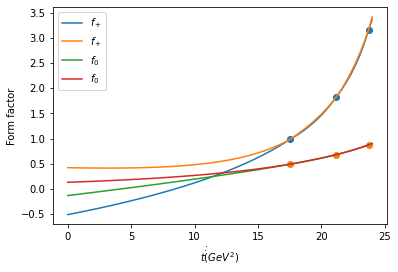

In [26]:
x = np.linspace(0,24,73)
plt.plot(x,[formfactor(dataplus,i,1,chi1minus) for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(datazero,i,0,chi0plus) for i in x],label = r"$f_0$")
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])

plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [22]:
##### Uncertainty #######

In [23]:
def dispmethod(chg,tchosen,Nboot):
    fbaruplist = []
    fbarlolist = []
    accepted_resamples = []
    nancount = 0
    unifailcount = 0
    extremumnotbestcount = 0
    
    for y in range(Nboot):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133
        
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
        
        plusbounds = formfactor(newdataplus,0,1,chiplus)
        zerobounds = formfactor(newdatazero,0,0,chizero)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdataplus,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        fbarup = 0
        fbarlo = np.Inf
        ########EXTREMUM CHECK############
#         ex_fbarup = 0
#         ex_fbarlo = np.Inf
        #####################################
        
        rangeN0 = np.linspace(lower,upper,N0)
        ########EXTREMUM CHECK############
#         for ex_k in [lower,upper]:
            
#             ex_originval = ex_k#np.random.uniform(lower,upper)
#             ex_extendednewdata = np.vstack([newdatachg,[0,ex_originval]])
#             ex_tchosenbounds = formfactor(ex_extendednewdata,tchosen,chg,chi)
#             ex_fbarup = max(ex_tchosenbounds[1],ex_fbarup)
#             ex_fbarlo = min(ex_tchosenbounds[0],ex_fbarlo)
        #####################################
        for k in rangeN0:
            
            originval = k#np.random.uniform(lower,upper)
            extendednewdata = np.vstack([newdatachg,[0,originval]])
            tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
            fbarup = max(tchosenbounds[1],fbarup)
            fbarlo = min(tchosenbounds[0],fbarlo)
            
#         if [ex_fbarlo,ex_fbarup] != [fbarlo,fbarup]:
#              extremumnotbestcount += 1
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
        accepted_resamples.append(newdata)
    print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    #print("for t = ",tchosen,", NBoot = ",Nboot ,", extremumnotbestcount = ",extremumnotbestcount)
    return [fbarlolist,fbaruplist,accepted_resamples]

In [125]:
tchosenlist = np.linspace(0,24,25)

In [128]:
Nboot = 50
dispresultsplus = np.empty([len(tchosenlist),4])
histplus = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_plus = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(1,tchosen,Nboot), dtype=np.object)
    dispresultsplus[counter,0] = tchosen
    averageffplus = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltaplus = result[0:2]-np.nanmean(result[0:2])
    varpluslo = np.sum(deltaplus[0]**2)/(len(result[0])-1)
    varplusup = np.sum(deltaplus[1]**2)/(len(result[0])-1)
    rhoplus = np.dot(deltaplus[0],deltaplus[1])/(len(result[0])-1)
    varplus = ((np.nanmean(result[0])-np.nanmean(result[1]))**2)/12 + (varpluslo+varplusup+rhoplus)/3 #*np.sqrt(varpluslo)*np.sqrt(varplusup)
    dispresultsplus[counter,1] = averageffplus
    dispresultsplus[counter,2] = averageffplus-np.sqrt(varplus)
    dispresultsplus[counter,3] = averageffplus+np.sqrt(varplus)
    histplus[counter,0] = tchosen
    histplus[counter,1] = result[0]
    histplus[counter,2] = result[1]
    accepted_dataset_plus[counter,0] = tchosen
    accepted_dataset_plus[counter,1] = result[2]
    counter += 1

discriminant is negative:  -1.8207710697997956e-21
M11 eigenvalues are:  [3.00960307e+00 1.48000925e-02 6.65296879e-03 7.26454156e-06]
for t =  0.0  unitarity fail percentage is  0.0 %
for t =  0.0  other fail percentage is  2.0 %
for t =  1.0  unitarity fail percentage is  0.0 %
for t =  1.0  other fail percentage is  0.0 %
for t =  2.0  unitarity fail percentage is  0.0 %
for t =  2.0  other fail percentage is  0.0 %
for t =  3.0  unitarity fail percentage is  0.0 %
for t =  3.0  other fail percentage is  0.0 %
discriminant is negative:  -7.70816858871337e-21
M11 eigenvalues are:  [3.00960307e+00 1.48001027e-02 6.65295806e-03 7.26471100e-06]
for t =  4.0  unitarity fail percentage is  0.0 %
for t =  4.0  other fail percentage is  2.0 %
for t =  5.0  unitarity fail percentage is  0.0 %
for t =  5.0  other fail percentage is  0.0 %
for t =  6.0  unitarity fail percentage is  0.0 %
for t =  6.0  other fail percentage is  0.0 %
for t =  7.0  unitarity fail percentage is  0.0 %
for t =  7

In [129]:
dispresultszero = np.empty([len(tchosenlist),4])
histzero = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_zero = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(0,tchosen,Nboot), dtype=np.object)
    dispresultszero[counter,0] = tchosen
    averageffzero = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltazero = result[0:2]-np.nanmean(result[0:2])
    varzerolo = np.sum(deltazero[0]**2)/(len(result[0])-1)
    varzeroup = np.sum(deltazero[1]**2)/(len(result[0])-1)
    rhozero = np.dot(deltazero[0],deltazero[1])/(len(result[0])-1)
    varzero = (np.nanmean(result[0])-np.nanmean(result[1]))**2/12 + (varzerolo+varzeroup+rhozero)/3 #*np.sqrt(varzerolo)*np.sqrt(varzeroup)
    dispresultszero[counter,1] = averageffzero
    dispresultszero[counter,2] = averageffzero-np.sqrt(varzero)
    dispresultszero[counter,3] = averageffzero+np.sqrt(varzero)                                           
    histzero[counter,0] = tchosen
    histzero[counter,1] = result[0]
    histzero[counter,2] = result[1]
    accepted_dataset_zero[counter,0] = tchosen
    accepted_dataset_zero[counter,1] = result[2]
    counter += 1

for t =  0.0  unitarity fail percentage is  0.0 %
for t =  0.0  other fail percentage is  0.0 %
discriminant is negative:  -3.92616983117005e-43
M11 eigenvalues are:  [4.05468761e+00 4.97011527e-02 1.47999606e-02 2.86960928e-04
 3.78381605e-07]
discriminant is negative:  -6.228488150738163e-43
M11 eigenvalues are:  [4.05468761e+00 4.97012961e-02 1.47999187e-02 2.86861081e-04
 3.77003583e-07]
discriminant is negative:  -1.105160231238193e-42
M11 eigenvalues are:  [4.05468761e+00 4.97008934e-02 1.48000635e-02 2.87112467e-04
 3.78881316e-07]
discriminant is negative:  -6.683182988884746e-43
M11 eigenvalues are:  [4.05468762e+00 1.48000390e-02 4.97008192e-02 2.87206397e-04
 3.78900289e-07]
discriminant is negative:  -3.193598651014721e-43
M11 eigenvalues are:  [4.05468762e+00 4.97009271e-02 1.47998747e-02 2.87258812e-04
 3.78262231e-07]
discriminant is negative:  -5.361529316583596e-44
M11 eigenvalues are:  [4.05468761e+00 4.97009099e-02 1.48000842e-02 2.87076272e-04
 3.78315802e-07]
discr

In [130]:
accepted_dataset_var = np.zeros([3,5])
accepted_dataset_plus_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_plus.shape[0]):
    for j in range(len(accepted_dataset_plus[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_plus[i][1][j][n][1]
        #print(temp_accepted_column)
        accepted_dataset_plus_stacked  = np.hstack((accepted_dataset_plus_stacked,temp_accepted_column))
accepted_dataset_plus_stacked = accepted_dataset_plus_stacked[:,1:]

ValueError: setting an array element with a sequence.

In [ ]:
accepted_dataset_zero_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_zero.shape[0]):
    for j in range(len(accepted_dataset_zero[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_zero[i][1][j][n][2]
        #print(temp_accepted_column)
        accepted_dataset_zero_stacked  = np.hstack((accepted_dataset_zero_stacked,temp_accepted_column))
accepted_dataset_zero_stacked = accepted_dataset_zero_stacked[:,1:]


In [ ]:
plt.hist(accepted_dataset_plus_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

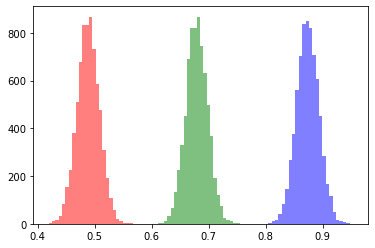

In [42]:
plt.hist(accepted_dataset_zero_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

In [43]:
accepted_dataset_var[:,0] = data[:,0]
#for i in range(3):
accepted_dataset_var[:,1] = np.mean(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,2] = np.std(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,3] = np.mean(accepted_dataset_zero_stacked,axis=1)
accepted_dataset_var[:,4] = np.std(accepted_dataset_zero_stacked,axis=1)
for i in range(accepted_dataset_var.shape[0]):
    for j in range(accepted_dataset_var.shape[1]):
        accepted_dataset_var[i,j] = round(accepted_dataset_var[i,j],4)
accepted_dataset_var

array([[2.37284e+01, 3.16570e+00, 3.83000e-02, 8.73800e-01, 1.96000e-02],
       [2.11562e+01, 1.82080e+00, 4.48000e-02, 6.79300e-01, 1.90000e-02],
       [1.75000e+01, 9.81600e-01, 5.42000e-02, 4.88800e-01, 1.95000e-02]])

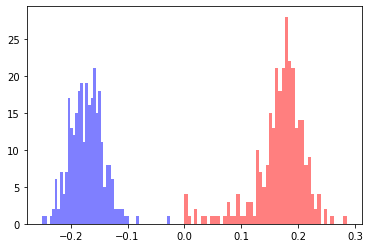

In [44]:
plt.hist(histzero[0,1],bins=50,color="blue", alpha=0.5)
plt.hist(histzero[0,2],bins=50,color="red", alpha=0.5)
plt.show()

In [45]:
len(histplus[0,2])

288

In [131]:
errortable = np.zeros([len(tchosenlist),5])
counter = 0
for t in tchosenlist:
    errortable[counter,0] = t
    errortable[counter,3] = round(dispresultszero[counter,1],3)
    errortable[counter,4] = round(dispresultszero[counter,1] - dispresultszero[counter,2],3)
    errortable[counter,1] = round(dispresultsplus[counter,1],3)
    errortable[counter,2] = round(dispresultsplus[counter,1] - dispresultsplus[counter,2],3)
    counter += 1

errortable

array([[0.000e+00, 6.000e-02, 1.060e-01, 8.800e-02, 1.020e-01],
       [1.000e+00, 8.500e-02, 9.900e-02, 1.020e-01, 1.010e-01],
       [2.000e+00, 1.060e-01, 9.600e-02, 1.140e-01, 8.800e-02],
       [3.000e+00, 1.240e-01, 9.200e-02, 1.150e-01, 8.800e-02],
       [4.000e+00, 1.400e-01, 7.800e-02, 1.140e-01, 7.900e-02],
       [5.000e+00, 1.630e-01, 8.500e-02, 1.380e-01, 6.500e-02],
       [6.000e+00, 1.970e-01, 7.900e-02, 1.580e-01, 7.100e-02],
       [7.000e+00, 2.190e-01, 7.400e-02, 1.710e-01, 5.600e-02],
       [8.000e+00, 2.400e-01, 6.600e-02, 2.000e-01, 5.200e-02],
       [9.000e+00, 2.910e-01, 5.500e-02, 2.270e-01, 5.300e-02],
       [1.000e+01, 3.410e-01, 5.500e-02, 2.480e-01, 4.400e-02],
       [1.100e+01, 3.760e-01, 4.800e-02, 2.850e-01, 3.500e-02],
       [1.200e+01, 4.450e-01, 4.500e-02, 2.960e-01, 3.600e-02],
       [1.300e+01, 5.150e-01, 4.200e-02, 3.270e-01, 3.000e-02],
       [1.400e+01, 5.820e-01, 3.100e-02, 3.550e-01, 2.700e-02],
       [1.500e+01, 6.790e-01, 3.700e-02,

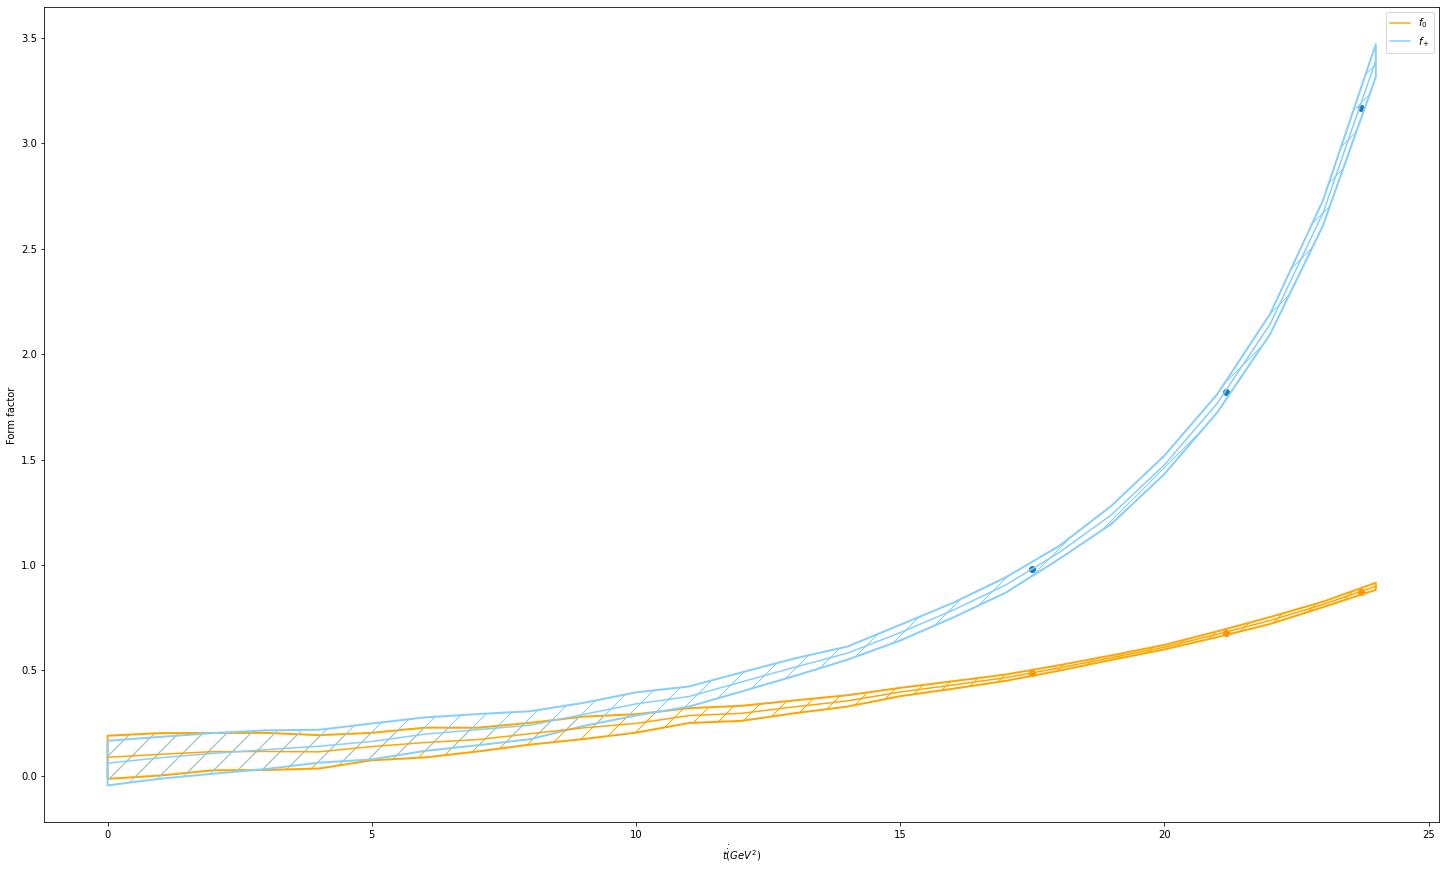

In [132]:
#x = np.linspace(0,2,101)
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])
plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$",color="orange")
pl.fill_between(dispresultszero[:,0],dispresultszero[:,2],dispresultszero[:,3],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(dispresultsplus[:,0],dispresultsplus[:,1],label = r"$f_+$",color="lightskyblue")
pl.fill_between(dispresultsplus[:,0],dispresultsplus[:,2],dispresultsplus[:,3],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [307]:
def zerohistogramdata(chg,Nboot):
    upperlist = []
    lowerlist = []
    unifailcount = 0
    for y in tqdm(range(Nboot)):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133
        
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
        
        bounds = formfactor(newdatazero,0,chg,chi)
        upper = bounds[1]
        lower = bounds[0]
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdatachg,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        
        upperlist.append(upper)
        lowerlist.append(lower)
    print("for t = 0 unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = 0 other fail percentage is ",((Nboot-len(lowerlist)-unifailcount)*100)/Nboot,"%")
    return [lowerlist,upperlist]

In [308]:
histresults = zerohistogramdata(1,5000)

100%|██████████| 5000/5000 [00:38<00:00, 129.49it/s]

for t = 0 unitarity fail percentage is  0.0 %
for t = 0 other fail percentage is  0.0 %


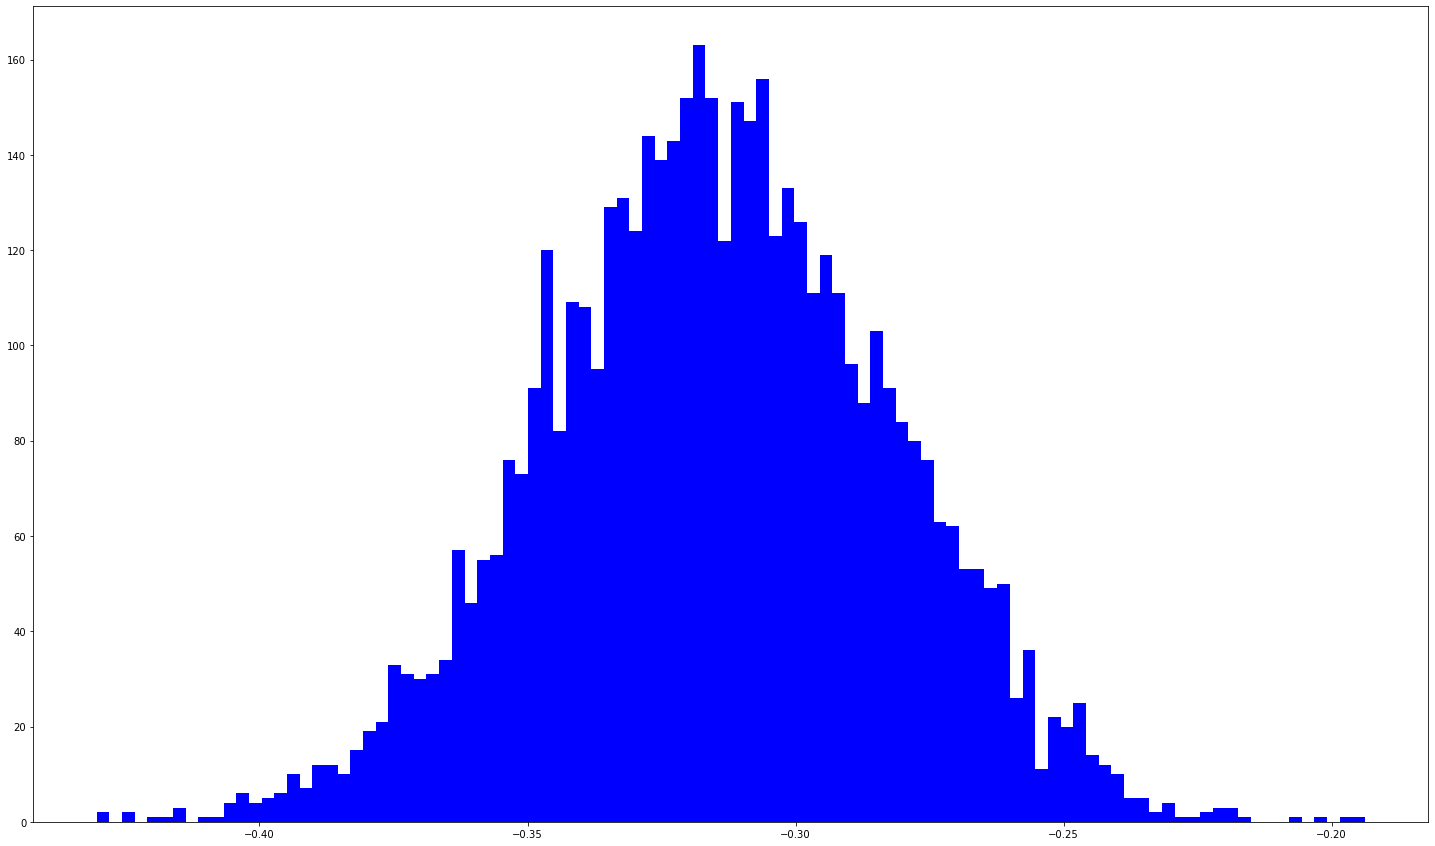

In [311]:
plt.hist(histresults[0],bins=100,color="blue", alpha=1)
plt.show()

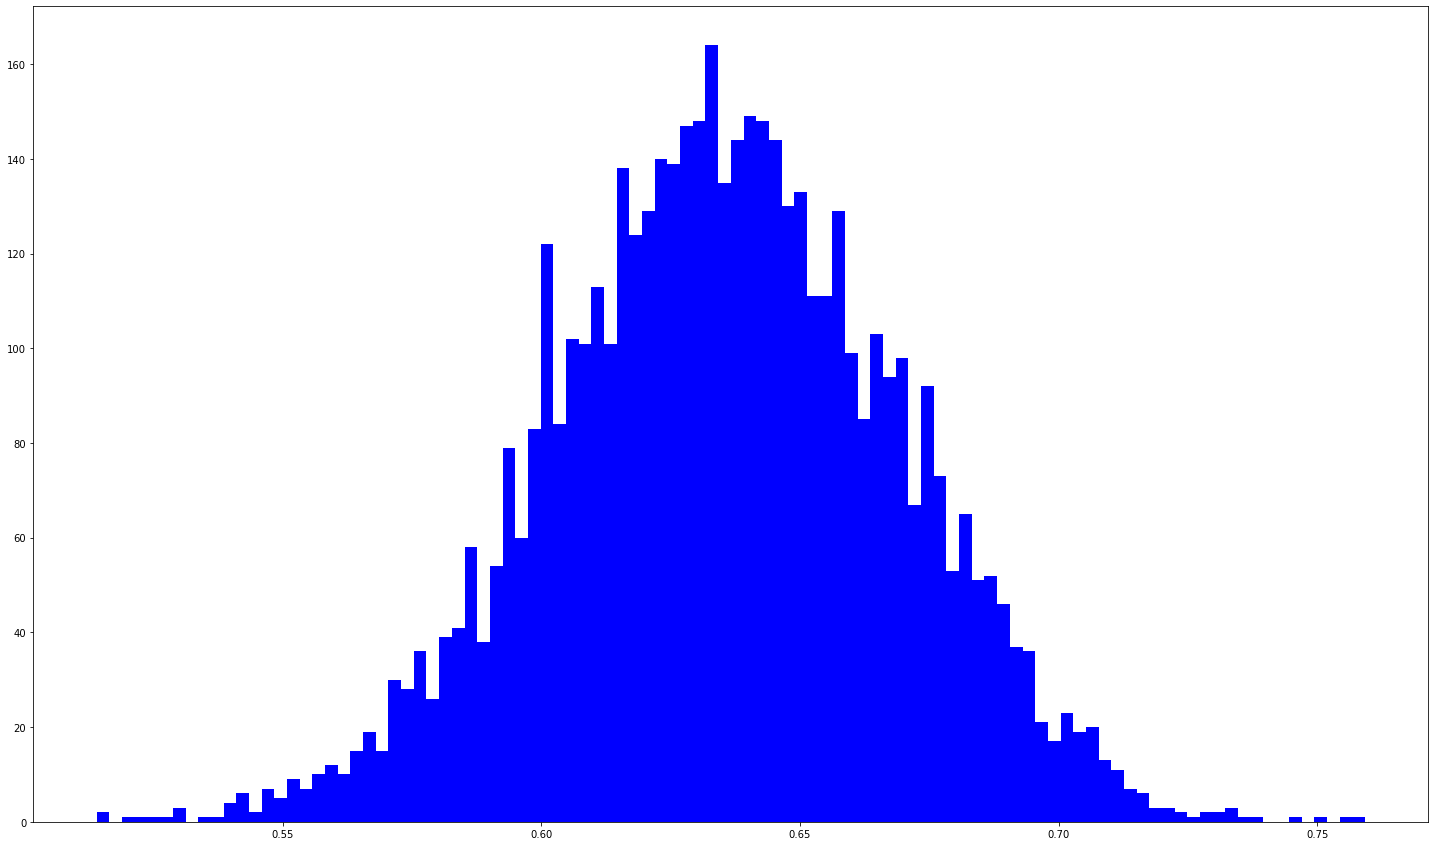

In [310]:
plt.hist(histresults[1],bins=100,color="blue", alpha=1)
plt.show()

In [234]:
histresultstable = np.zeros([1,4])
histresultstable[0,0] = np.mean(histresults[0])
histresultstable[0,1] = np.std(histresults[0])
histresultstable[0,2] = np.mean(histresults[1])
histresultstable[0,3] = np.std(histresults[1])
for i in range(histresultstable.shape[0]):
    for j in range(histresultstable.shape[1]):
        histresultstable[i,j] = round(histresultstable[i,j],4)
histresultstable

array([[0.7521, 0.0304, 0.7794, 0.0304]])

In [161]:
def dispmethod_overlap(chg,tchosen,Nboot,N0,N0index):
    fbaruplist = []
    fbarlolist = []
    accepted_resamples = []
    nancount = 0
    unifailcount = 0
    extremumnotbestcount = 0
    if chg == 1:
            phi = phiplus
    if chg == 0:
            phi = phizero
    #print(phi(tchosen))
    printval = 0
    for y in range(Nboot):
        newdata = covresample(bskpts)
        newdataplus = newdata[0]
        newdatazero = newdata[1]
        
        chiplus = np.random.normal(chi1minus,0)#0.00036
        chizero = np.random.normal(chi0plus,0)#0.00133 
        if chg == 1:
            chi = chiplus
            newdatachg = newdataplus
            phi = phiplus
        if chg == 0:
            chi = chizero
            newdatachg = newdatazero
            phi = phizero
        
        plusbounds = formfactor(newdataplus,0,1,chiplus)
        zerobounds = formfactor(newdatazero,0,0,chizero)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdataplus,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdatazero,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        fbarup = 0
        fbarlo = np.Inf
        ########EXTREMUM CHECK############
#         ex_fbarup = 0
#         ex_fbarlo = np.Inf
        #####################################
        
        rangeN0 = np.linspace(lower,upper,N0)
        ########EXTREMUM CHECK############
#         for ex_k in [lower,upper]:
            
#             ex_originval = ex_k#np.random.uniform(lower,upper)
#             ex_extendednewdata = np.vstack([newdatachg,[0,ex_originval]])
#             ex_tchosenbounds = formfactor(ex_extendednewdata,tchosen,chg,chi)
#             ex_fbarup = max(ex_tchosenbounds[1],ex_fbarup)
#             ex_fbarlo = min(ex_tchosenbounds[0],ex_fbarlo)
        #####################################
        kval = lower + (upper-lower)*N0index/N0
        
        originval = kval#np.random.uniform(lower,upper)
        extendednewdata = np.vstack([newdatachg,[0,originval]])
        tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
        
        #print(np.linalg.eig(M11(extendednewdata,tchosen,chg,chi))[0])
        #print(np.linalg.det(M11(extendednewdata,tchosen,chg,chi)))
        print(beta(extendednewdata,tchosen,chg))
#         comparisonvar = alpha(extendednewdata)*phi(tchosen)
#         if printval != comparisonvar:
#             print(comparisonvar)
#         printval = comparisonvar
        fbarup = max(tchosenbounds[1],fbarup)
        fbarlo = min(tchosenbounds[0],fbarlo)
        #print([fbarlo,fbarup])
#         if [ex_fbarlo,ex_fbarup] != [fbarlo,fbarup]:
#              extremumnotbestcount += 1
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
        accepted_resamples.append(newdata)
    #print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    #print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    #print("for t = ",tchosen,", NBoot = ",Nboot ,", extremumnotbestcount = ",extremumnotbestcount)
    return [fbarlolist,fbaruplist,accepted_resamples]

In [162]:
###Investigating why extrema are not optimal at t=23 ###
tchoices = np.linspace(21,25,5)#[23]
N0 = 10
exresults = np.zeros([len(tchoices),3,N0+1])
tindex = 0
charge = 0
for tchoice in tqdm(tchoices):
    counter = 0
    for N0index in np.linspace(0,N0,N0+1):
        tempresults = dispmethod_overlap(charge,tchoice,1,N0,N0index)
        exresults[tindex,0,counter] = N0index
        exresults[tindex,1,counter] = np.mean(tempresults[0])
        exresults[tindex,2,counter] = np.mean(tempresults[1])
        counter += 1
    tindex += 1

  0%|          | 0/5 [00:00<?, ?it/s]

discriminant is negative:  -3.527445989418545e-46
M11 eigenvalues are:  [4.05468761e+00 4.97009626e-02 1.48000452e-02 2.87064980e-04
 3.78266445e-07]
-2.5479708860143114e-13
-2.564703794367775e-13
-2.605588912748711e-13
-2.6562235147223485e-13
-2.6404831160183943e-13
-2.6875796333521497e-13
-2.6693061643041896e-13
-2.6413605170395224e-13
-2.638089639577744e-13
-2.712036301949709e-13
-2.6465644651114415e-13


 20%|██        | 1/5 [00:00<00:02,  1.41it/s]

discriminant is negative:  -1.7144103722740803e-44
M11 eigenvalues are:  [4.05468761e+00 4.97008408e-02 1.48000851e-02 2.87142197e-04
 3.78680422e-07]
-2.927360762673654e-13
-2.9202723369774955e-13
-2.930978725210139e-13
-2.9403200898594396e-13
-2.8044862087924165e-13
-2.8527290996477217e-13
-2.9107218647541856e-13
-2.923315724441823e-13
-3.0296637214271127e-13

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]


-2.9946575826025574e-13
-2.9150671532015826e-13
-3.0331855592563755e-13
-3.195561903495164e-13
-3.166439719219623e-13
-3.048954587392316e-13
-3.0844421325938286e-13
-3.185887355907779e-13
-3.112507819927824e-13
-3.183715100286359e-13
-3.100044324077926e-13


 60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

-3.231042032091394e-13
-3.106703367284771e-13
-3.39212167270152e-13
-3.385774260533069e-13
-3.441993091642439e-13
-3.5087851420107746e-13
-3.377440110848687e-13
-3.440278393559216e-13
-3.380498547093931e-13
-3.439359507537611e-13
-3.474480701033483e-13
-3.529947505154319e-13
-3.509533598841415e-13

 80%|████████  | 4/5 [00:02<00:00,  1.46it/s]


discriminant is negative:  -2.5305417731492085e-43
M11 eigenvalues are:  [4.05468761e+00 4.97011617e-02 1.47999906e-02 2.86922376e-04
 3.77329522e-07]
-3.834753986919084e-13
-3.7013734454490457e-13
-3.8059292677848544e-13
-3.800892738158586e-13
-3.8124603598629245e-13
-3.6116244133319186e-13
-3.785054758386636e-13
-3.6575563705983915e-13
-3.880177943688214e-13
-3.6391467241958785e-13
-3.7393023508215646e-13

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

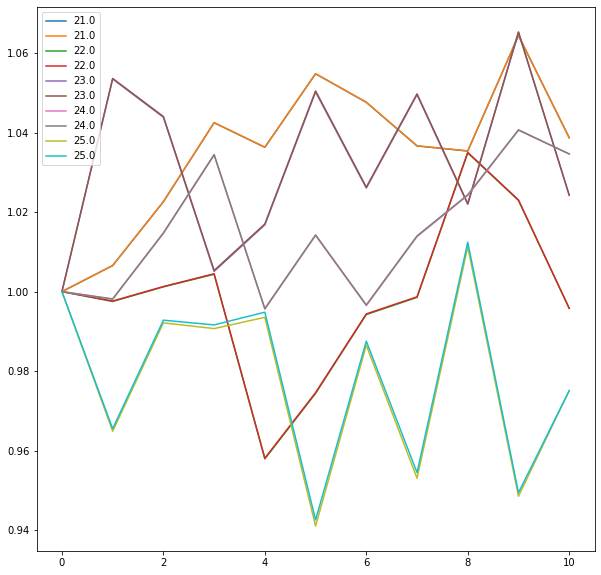

In [163]:
for i in range(0,len(tchoices)):
    plt.plot(exresults[i,0,:],exresults[i,1,:]/exresults[i,1,0],label=tchoices[i])
    plt.plot(exresults[i,0,:],exresults[i,2,:]/exresults[i,1,0],label=tchoices[i])
plt.legend()

plt.rcParams["figure.figsize"] = (25,15)
plt.show()